In [1]:
!pip install yfinance numpy pandas matplotlib tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 3.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=300451 sha256=66954e95bc061bd06d73aa8b7a6d716af009a2a8800acf7a816654617c1872df
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## Downloading Stock Data from Yahoo Finance

In [3]:
data = yf.download('AAPL', start='2010-01-01', end='2023-11-01')
data = data[['Close']]
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2010-01-04 00:00:00+00:00,7.643214
2010-01-05 00:00:00+00:00,7.656429
2010-01-06 00:00:00+00:00,7.534643
2010-01-07 00:00:00+00:00,7.520714
2010-01-08 00:00:00+00:00,7.570714


## Data Preprocessing

### Scaling the data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


### Creating the sequence

In [5]:
print(len(scaled_data))

3481


In [6]:
sequence_length = 60
x_train = []
y_train = []

for i in range(sequence_length, len(scaled_data)):
    x_train.append(scaled_data[i-sequence_length:i, 0])
    y_train.append(scaled_data[i, 0])
    
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build the RNN Model

In [7]:
model  = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

#Adding output layer

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Training the model

In [8]:
model.fit(x_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0238
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014
Epoch 8/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 9/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0016
Epoch 10/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014
Epoch 11/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011
Epoch 12/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 13/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 14/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0012
Epoch 15/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s

## Preparing test data for predictions

### Preparing test data

In [9]:
# Prepare test data by including more rows from the original dataset for enough sequences
full_data = data.values  # Use the complete dataset
test_data = full_data[len(full_data) - len(data) - sequence_length * 2:]  # Extend range

# Scale the expanded test data
test_data = scaler.transform(test_data.reshape(-1, 1))

# Create input sequences for `x_test`
x_test = []
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

x_test = np.array(x_test)

# Reshape `x_test` to 3D (samples, sequence_length, features)
if x_test.size > 0:
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
else:
    print("x_test is still empty; try adjusting `sequence_length` or adding more data.")


In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


## Trying to Visualize Specific Time Duration

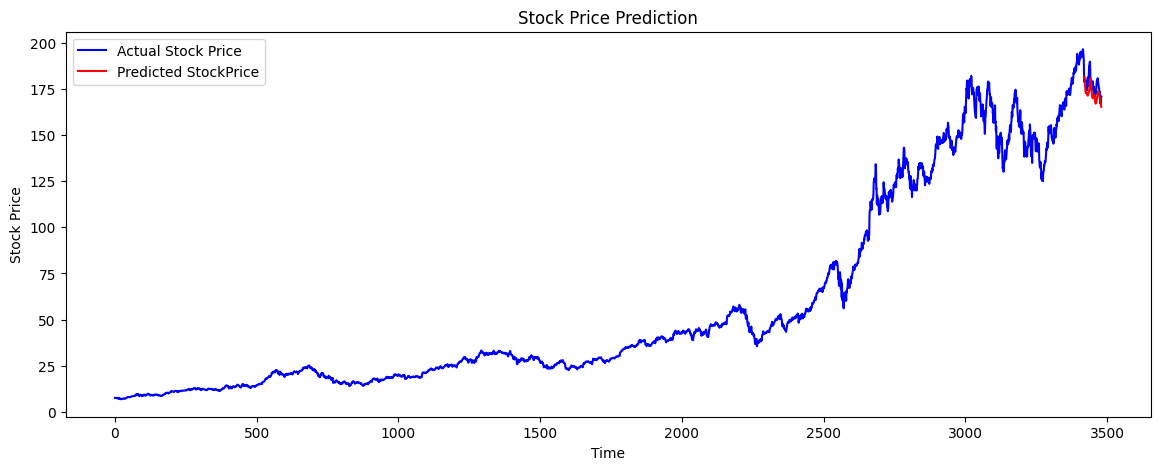

In [11]:
plt.figure(figsize=(14, 5))
plt.plot(data.values, color='blue', label='Actual Stock Price')
plt.plot(range(len(data)-len(predictions), len(data)), predictions, color='red', label='Predicted StockPrice')
plt.title('Stock Price Prediction')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = scaler.inverse_transform(test_data[sequence_length:])
y_pred = predicted_prices = scaler.inverse_transform(predictions)  # Model's predictions
mae = mean_absolute_error(y_true, y_pred)  # Replace with actual and predicted values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")

Mean Absolute Error: 32469.240009562174
Root Mean Square Error: 32476.5715747424


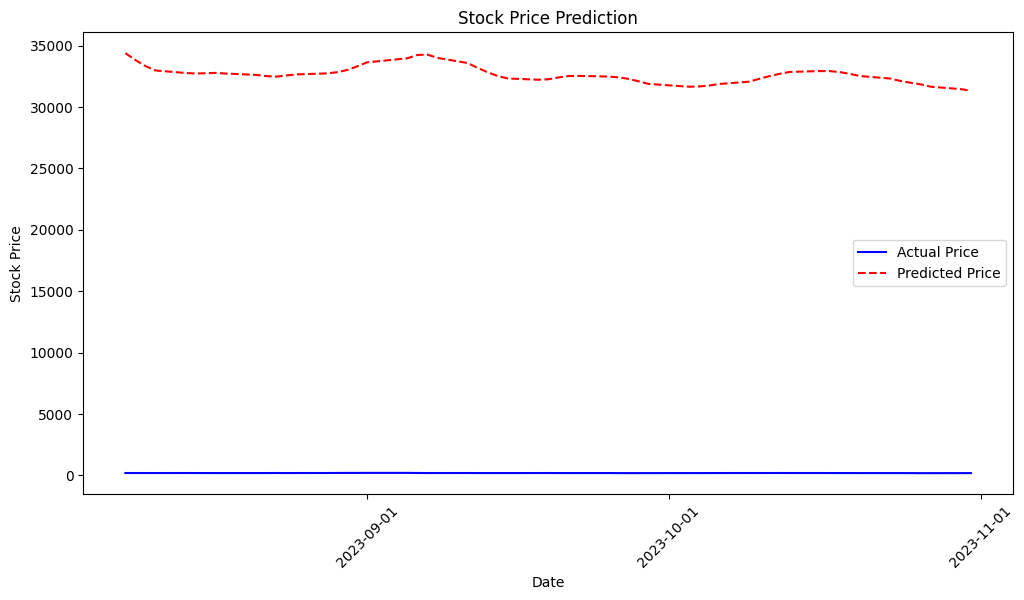

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Assuming 'sequence_length' was defined earlier as 60
dates = data.index[-len(test_data):]  # Get dates for the test set
dates = dates[sequence_length:]       # Skip the first sequence_length dates
actual_prices = scaler.inverse_transform(test_data[sequence_length:])
predicted_prices = scaler.inverse_transform(predictions)
# Now plot with matched lengths
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, color='blue', label='Actual Price')
plt.plot(dates, predicted_prices, color='red', linestyle='--', label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()

# Format x-axis to show dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Adjust interval as needed

plt.xticks(rotation=45)
plt.show()
otation=(45)
plt.show()


## Evaluating Model Performance

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = scaler.inverse_transform(test_data[sequence_length:])
y_pred = predicted_prices = scaler.inverse_transform(predictions)  # Model's predictions
mae = mean_absolute_error(y_true, y_pred)  # Replace with actual and predicted values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Square Error: {rmse}")


Mean Absolute Error: 32469.240009562174
Root Mean Square Error: 32476.5715747424
